#Previsão do Consumo de combustível

Aplicando **Regressão**.

Um problema de regressão tem como objetivo prever as saídas (outputs) de um valor contínuo, como um preço ou probabilidade.

O modelo apresentado, tem como objetivo além da aplicação da Regressão, a previsão do consumo de combustível do final dos anos 1970, início dos anos 1980. Para isso, forneceremos um modelo com descrição de vários automóveis desse período.


Base de Dados: [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)



###**Preparando o ambiente**

In [1]:
!pip install -q seaborn

In [3]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#Conferindo a versão do TensorFlow
print(tf.__version__)

2.5.0


###**Importando o Dataset**

Base de Dados: [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)


In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 4us/step


In [5]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names =column_names, na_values="?", comment ='\t', sep = " ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


###**Limpando os dados**

Informação de Atributo:

1. mpg: contínuo
2. cilindros: discreto multivalorado
3. deslocamento: contínuo
4. cavalos de força: contínua
5. peso: contínuo
6. aceleração: contínua
7. ano do modelo: discreto multivalorado
8. origem: discreto multivalorado
9. nome do carro: string (único para cada instância)

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Como observado acima, há 6 campos vazios no Dataset. Esses campos devem ser eliminados para a execução correta do modelo.

In [7]:
dataset = dataset.dropna()

A coluna "Origin" é uma coluna categórica e não numérica, logo é convertida para one-hot.
****

*Aplicando one-hot-encoding, as categorias se transformaram em colunas (variáveis) onde o número 1 representa o valor afirmativo e o 0 negativo.*

In [8]:
origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


###**Explorando os dados**

Separando entre treinamento e teste.


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

**MPG** = Milhas por galão

**Cylinders** = Cilindors

**Displacement** = Deslocamento

**Weight** = Peso

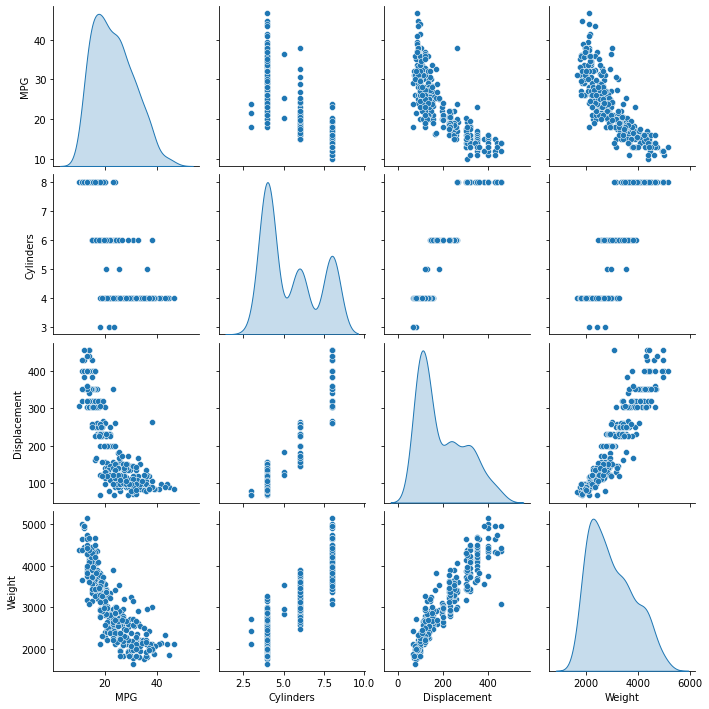

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind= "kde");

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


###**Separando *features* de *labels***

Separando o valor alvo (labels), das features. 

Esta label é o valor no qual o model é treinado para prever.



In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

###**Normalizando os dados**


*Uma boa prática é normalizar as features que usam diferentes escalas e intervalos. Apesar do modelo poder convergir sem a normalização, isso torna o treinamento mais difícil, e torna o resultado do modelo dependente da escolha das unidades da entrada.*

Fonte: TensorFlow tutorials

In [15]:
def norm(x):
  return (x-train_stats['mean']) / train_stats['std']

#Aplicando Normalização no treino e teste Dataset:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

###**Construindo o modelo**

**Mean Squared Error(MSE)**, é uma função comum de loss usada para problemas de regressão (diferentes funções de loss são usadas para problemas de classificação).

**Mean Absolute Error (MAE)**  é uma métrica comum de regressão.



In [18]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [19]:
model = build_model()

###**Examinando o modelo**

Com 3 camadas densas

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Batch de 10 exemplos do conjunto de treinamento:

In [21]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 5.1516518e-03],
       [-7.2048977e-05],
       [-1.7294778e-01],
       [-3.0734409e-02],
       [ 2.8438631e-01],
       [-7.8551590e-02],
       [ 3.0464187e-01],
       [-2.0721899e-01],
       [-6.1422415e-02],
       [ 1.3431753e-01]], dtype=float32)

###**Treinando o modelo**

**Treinando o modelo com 1000 epochs:**

In [22]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

**Histórico dos 10 últimos epochs usados para o treinamento**

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.535620,0.977600,2.535620,10.336247,2.488099,10.336247,995
996,2.459299,0.988946,2.459299,10.430243,2.497939,10.430243,996
997,2.663308,1.010412,2.663308,10.164233,2.471771,10.164233,997
998,2.603780,1.022462,2.603780,10.405145,2.502860,10.405145,998
999,2.426301,0.960902,2.426301,10.218737,2.469299,10.218737,999


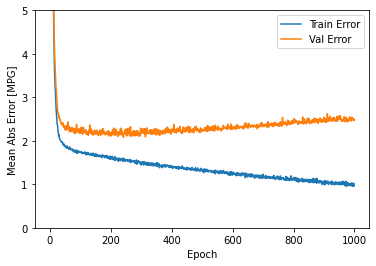

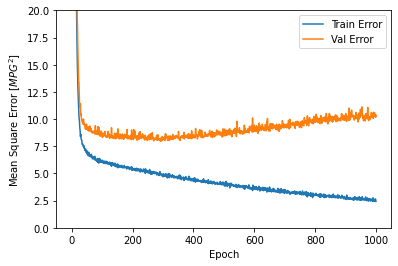

In [24]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

O gráfico apresenta pequenas melhoras após 100 epochs.


****

Agora, será atualizado o `model.fit` para que pare automaticamente o treinamento quando o `validation score` não aumentar mais.

Será utilizado o `EarlyStopping callback` que testa a condição do treinamento a cada epoch.

Se um grupo de epochs decorre sem mostrar melhoras, o treinamento irá parar automaticamente.

****
Por que isso é necessário?

Porque pode ocorrer **Overfitting**.

**Overfitting** ocorre quando, nos dados de treino, o modelo tem um desempenho excelente, porém quando utilizamos os dados de teste o resultado é ruim. Podemos entender que, neste caso, o modelo aprendeu tão bem as relações existentes no treino, que acabou apenas decorando o que deveria ser feito, e ao receber as informações das variáveis preditoras nos dados de teste, o modelo tenta aplicar as mesmas regras decoradas, porém com dados diferentes esta regra não tem validade, e o desempenho é afetado. 

Fonte: Didatica.tech




......................................................................

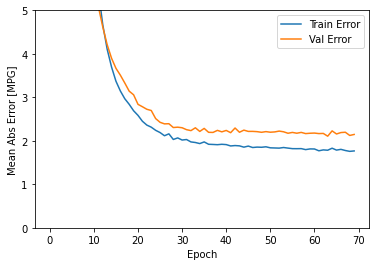

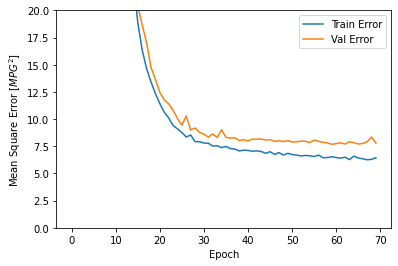

In [25]:
model = build_model()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

**O gráfico mostra que no conjunto de validação, a média de erro é próximo de +/- 2MPG**

In [26]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7490 - mae: 1.9060 - mse: 5.7490
Testing set Mean Abs Error:  1.91 MPG


###**Predições**

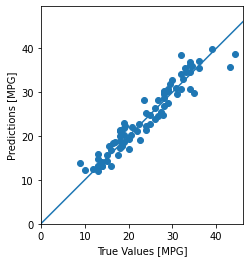

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

###**Distribuição do erro**

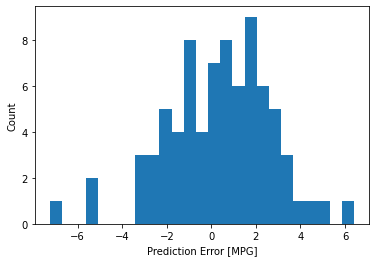

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")